
# Popularity Prediction Model Comparison

This notebook trains and compares multiple models to predict movie **popularity**.
It includes baseline, linear, ensemble, and advanced gradient-boosting models.

## Objectives
- Build a reproducible supervised regression pipeline.
- Compare simple and complex models under the same split/metrics.
- Evaluate performance with both holdout and cross-validation.
- Visualize results and interpret the best model.



## 1. Imports and Environment Checks

We import standard ML libraries and then check optional availability of:
- **XGBoost** (`xgboost`)
- **LightGBM** (`lightgbm`)

If not installed, the notebook skips those models automatically.

Additional evaluation metrics included in this version:
- `MedAE` (median absolute error)
- `MAPE` (mean absolute percentage error)
- `ExplainedVariance`
- `MaxError`


In [80]:

import time
import importlib.util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error,
    explained_variance_score,
    max_error,
)

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

RANDOM_STATE = 42
sns.set_theme(style='whitegrid')

HAS_XGBOOST = importlib.util.find_spec('xgboost') is not None
HAS_LIGHTGBM = importlib.util.find_spec('lightgbm') is not None

if HAS_XGBOOST:
    from xgboost import XGBRegressor
if HAS_LIGHTGBM:
    from lightgbm import LGBMRegressor

print('xgboost available:', HAS_XGBOOST)
print('lightgbm available:', HAS_LIGHTGBM)


xgboost available: True
lightgbm available: True



## 2. Load the Engineered Supervised Dataset

Input file: `../data/data_supervised_popularity.csv`
- Features: engineered pre-release variables
- Target: `popularity`


In [81]:

df = pd.read_csv('../data/data_supervised_popularity.csv')
print('Shape:', df.shape)
print('Columns:', len(df.columns))
df.head(3)


Shape: (9290, 53)
Columns: 53


,runtime,director_popularity,actor1_popularity,actor2_popularity,actor3_popularity,actor4_popularity,actor5_popularity,cast_pop_mean,cast_pop_max,release_month,...,lang_de,lang_other,is_english,revenue_missing_flag,budget_missing_flag,has_budget,log_budget,has_overview,overview_length,popularity
0,148,8.2813,12.2774,5.6445,4.5824,9.6156,4.8289,7.38976,12.2774,7.0,...,0,0,1,0,0,1,18.890684,1,280,32.8952
1,100,5.1258,2.1981,1.9780,1.8252,4.9563,2.1777,2.62706,4.9563,11.0,...,0,0,1,0,0,1,19.376192,1,286,19.8760
2,124,4.0024,9.2587,5.5278,3.4058,17.8153,4.4974,8.10100,17.8153,4.0,...,0,0,1,0,0,1,19.113828,1,372,13.7900


In [82]:
print('Top missing counts:')
print(df.isna().sum().sort_values(ascending=False).head(10))

print()
print('Target describe:')
print(df['popularity'].describe())


Top missing counts:
runtime                  0
genre_History            0
genre_Music              0
genre_Mystery            0
genre_Romance            0
genre_Science Fiction    0
genre_TV Movie           0
genre_Thriller           0
genre_War                0
genre_Western            0
dtype: int64

Target describe:
count    9290.000000
mean        5.788687
std         7.689172
min         2.414700
25%         3.885000
50%         4.501300
75%         5.628275
max       378.004500
Name: popularity, dtype: float64



## 3. Explore the Target Distribution

Popularity is typically right-skewed, so this plot helps contextualize error metrics.


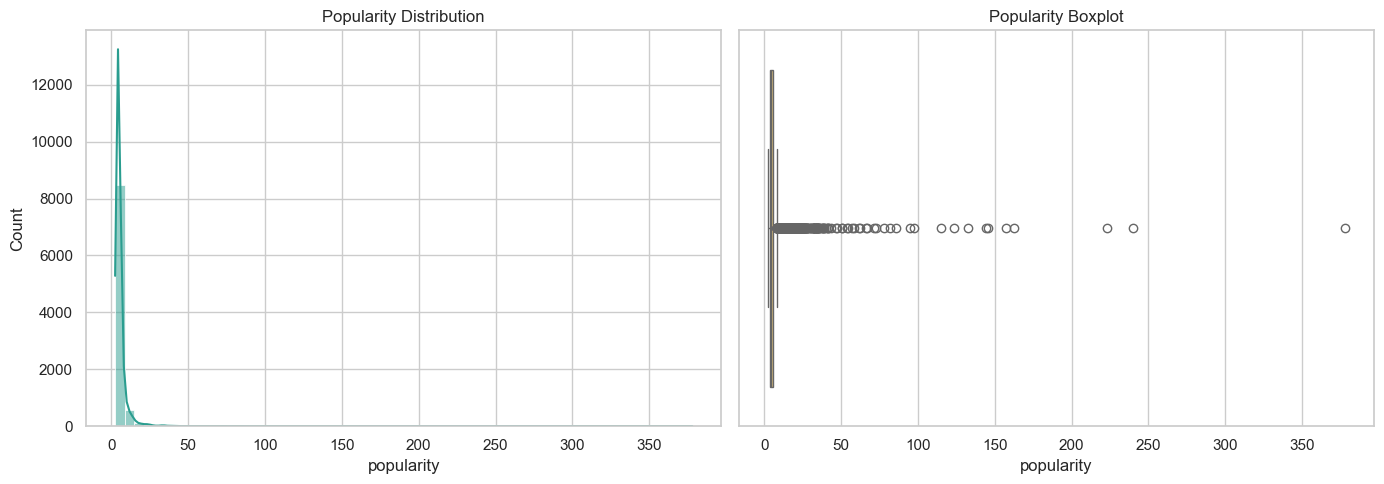

In [83]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['popularity'], bins=60, kde=True, ax=axes[0], color='#2a9d8f')
axes[0].set_title('Popularity Distribution')
axes[0].set_xlabel('popularity')

sns.boxplot(x=df['popularity'], ax=axes[1], color='#e9c46a')
axes[1].set_title('Popularity Boxplot')
axes[1].set_xlabel('popularity')

plt.tight_layout()
plt.show()



## 4. Train/Test Split

We keep 20% as a final holdout test set.


In [84]:

X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print('X_train:', X_train.shape)
print('X_test: ', X_test.shape)


X_train: (7432, 52)
X_test:  (1858, 52)



## 5. Define Model Set

Models included:
- Baseline: `DummyRegressor`
- Linear: `LinearRegression`, `RidgeCV`
- Tree Ensembles: `RandomForest`, `ExtraTrees`, `GradientBoosting`, `HistGradientBoosting`
- Advanced Boosters: `XGBoost`, `LightGBM` (if installed)


In [85]:

models = {
    'Dummy Mean': Pipeline([
        ('model', DummyRegressor(strategy='mean'))
    ]),
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'RidgeCV': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RidgeCV(alphas=np.logspace(-3, 3, 13)))
    ]),
    'Random Forest': Pipeline([
        ('model', RandomForestRegressor(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    'Extra Trees': Pipeline([
        ('model', ExtraTreesRegressor(
            n_estimators=500,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    'Gradient Boosting': Pipeline([
        ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
    ]),
    'Hist Gradient Boosting': Pipeline([
        ('model', HistGradientBoostingRegressor(random_state=RANDOM_STATE))
    ])
}

if HAS_XGBOOST:
    models['XGBoost'] = Pipeline([
        ('model', XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.85,
            colsample_bytree=0.85,
            objective='reg:squarederror',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

if HAS_LIGHTGBM:
    models['LightGBM'] = Pipeline([
        ('model', LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.85,
            colsample_bytree=0.85,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

print('Models to run:')
for m in models:
    print('-', m)


Models to run:
- Dummy Mean
- Linear Regression
- RidgeCV
- Random Forest
- Extra Trees
- Gradient Boosting
- Hist Gradient Boosting
- XGBoost
- LightGBM



## 6. Train, Cross-Validate, and Score

Metrics:
- **MAE**: average absolute error
- **RMSE**: penalizes larger errors
- **R2**: explained variance relative to mean baseline
- **MedAE**: robust typical absolute error
- **MAPE**: relative percentage error
- **ExplainedVariance**: variance captured by predictions
- **MaxError**: worst-case absolute error
- **CV_RMSE**: 3-fold mean RMSE on training split
- **FitTimeSec**: training time for complexity/performance tradeoff


In [86]:

results = []
fitted_models = {}
test_predictions = {}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

y_range = max(y_test.max() - y_test.min(), 1e-9)

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    exp_var = explained_variance_score(y_test, y_pred)
    mx_err = max_error(y_test, y_pred)
    nrmse = rmse / y_range

    cv_rmse = -cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    ).mean()

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MedAE': medae,
        'MAPE': mape,
        'ExplainedVariance': exp_var,
        'MaxError': mx_err,
        'NRMSE': nrmse,
        'CV_RMSE': cv_rmse,
        'FitTimeSec': fit_time
    })

    fitted_models[name] = model
    test_predictions[name] = y_pred

results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)

# Rank-based composite for easier multi-metric comparison
rank_lower_better = ['MAE', 'RMSE', 'MedAE', 'MAPE', 'MaxError', 'NRMSE', 'CV_RMSE', 'FitTimeSec']
rank_higher_better = ['R2', 'ExplainedVariance']

for col in rank_lower_better:
    results_df[f'Rank_{col}'] = results_df[col].rank(method='min', ascending=True)
for col in rank_higher_better:
    results_df[f'Rank_{col}'] = results_df[col].rank(method='min', ascending=False)

rank_cols = [c for c in results_df.columns if c.startswith('Rank_')]
results_df['AvgRank'] = results_df[rank_cols].mean(axis=1)
results_df = results_df.sort_values(['RMSE', 'AvgRank']).reset_index(drop=True)

results_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3146
[LightGBM] [Info] Number of data points in the train set: 7432, number of used features: 52
[LightGBM] [Info] Start training from score 5.842702
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 4954, number of used features: 52
[Li

,Model,MAE,RMSE,R2,MedAE,MAPE,ExplainedVariance,MaxError,NRMSE,CV_RMSE,...,Rank_RMSE,Rank_MedAE,Rank_MAPE,Rank_MaxError,Rank_NRMSE,Rank_CV_RMSE,Rank_FitTimeSec,Rank_R2,Rank_ExplainedVariance,AvgRank
0,XGBoost,1.626463,4.185346,0.314174,0.759325,0.256156,3.154477e-01,70.477079,0.029496,7.614286,...,1.0,2.0,1.0,3.0,1.0,5.0,5.0,1.0,1.0,2.1
1,Gradient Boosting,1.685983,4.431288,0.231204,0.771642,0.262510,2.321372e-01,70.068337,0.031229,7.699749,...,2.0,6.0,2.0,2.0,2.0,6.0,7.0,2.0,3.0,3.5
2,Random Forest,1.672186,4.439115,0.228486,0.763136,0.269342,2.328539e-01,68.982040,0.031285,7.301699,...,3.0,4.0,3.0,1.0,3.0,3.0,9.0,3.0,2.0,3.3
3,RidgeCV,2.067456,4.683050,0.141364,1.335009,0.362587,1.432700e-01,130.308302,0.033004,7.841485,...,4.0,7.0,7.0,8.0,4.0,7.0,3.0,4.0,4.0,5.5
4,Linear Regression,2.190431,4.732834,0.123012,1.460261,0.388597,1.245312e-01,129.618872,0.033355,7.849961,...,5.0,8.0,9.0,7.0,5.0,8.0,2.0,5.0,5.0,6.3
5,LightGBM,1.839230,4.756288,0.114298,0.760354,0.283805,1.144391e-01,75.015338,0.033520,7.510146,...,6.0,3.0,6.0,4.0,6.0,4.0,4.0,6.0,6.0,5.1
6,Hist Gradient Boosting,1.772528,4.800057,0.097922,0.741571,0.271376,9.961133e-02,76.260340,0.033828,7.290314,...,7.0,1.0,4.0,5.0,7.0,1.0,6.0,7.0,7.0,5.0
7,Dummy Mean,2.158683,5.061085,-0.002856,1.657452,0.370166,-2.220446e-16,138.467998,0.035668,8.206709,...,8.0,9.0,8.0,9.0,8.0,9.0,1.0,8.0,8.0,7.6
8,Extra Trees,1.690371,5.141636,-0.035032,0.768522,0.277719,-2.953899e-02,116.218597,0.036236,7.290559,...,9.0,5.0,5.0,6.0,9.0,2.0,8.0,9.0,9.0,6.6


## 7. Metrics Comparison Table and Visual Comparison

First, we create a compact table to compare all model metrics side-by-side.
Then we visualize core metrics with bar charts and a standardized heatmap.


,Model,MAE,RMSE,R2,MedAE,MAPE,ExplainedVariance,MaxError,NRMSE,CV_RMSE,FitTimeSec,AvgRank
0,XGBoost,1.626,4.185,0.3142,0.759,0.2562,0.3154,70.477,0.0295,7.614,0.718,2.10
1,Gradient Boosting,1.686,4.431,0.2312,0.772,0.2625,0.2321,70.068,0.0312,7.700,2.634,3.50
2,Random Forest,1.672,4.439,0.2285,0.763,0.2693,0.2329,68.982,0.0313,7.302,7.316,3.30
3,RidgeCV,2.067,4.683,0.1414,1.335,0.3626,0.1433,130.308,0.0330,7.841,0.457,5.50
4,Linear Regression,2.190,4.733,0.1230,1.460,0.3886,0.1245,129.619,0.0334,7.850,0.032,6.30
5,LightGBM,1.839,4.756,0.1143,0.760,0.2838,0.1144,75.015,0.0335,7.510,0.710,5.10
6,Hist Gradient Boosting,1.773,4.800,0.0979,0.742,0.2714,0.0996,76.260,0.0338,7.290,0.780,5.00
7,Dummy Mean,2.159,5.061,-0.0029,1.657,0.3702,-0.0000,138.468,0.0357,8.207,0.015,7.60
8,Extra Trees,1.690,5.142,-0.0350,0.769,0.2777,-0.0295,116.219,0.0362,7.291,4.660,6.60


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/3023679878.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='RMSE', y='Model', ax=axes[0, 0], palette='viridis')
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/3023679878.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='MAE', y='Model', ax=axes[0, 1], palette='mako')
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/3023679878.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='

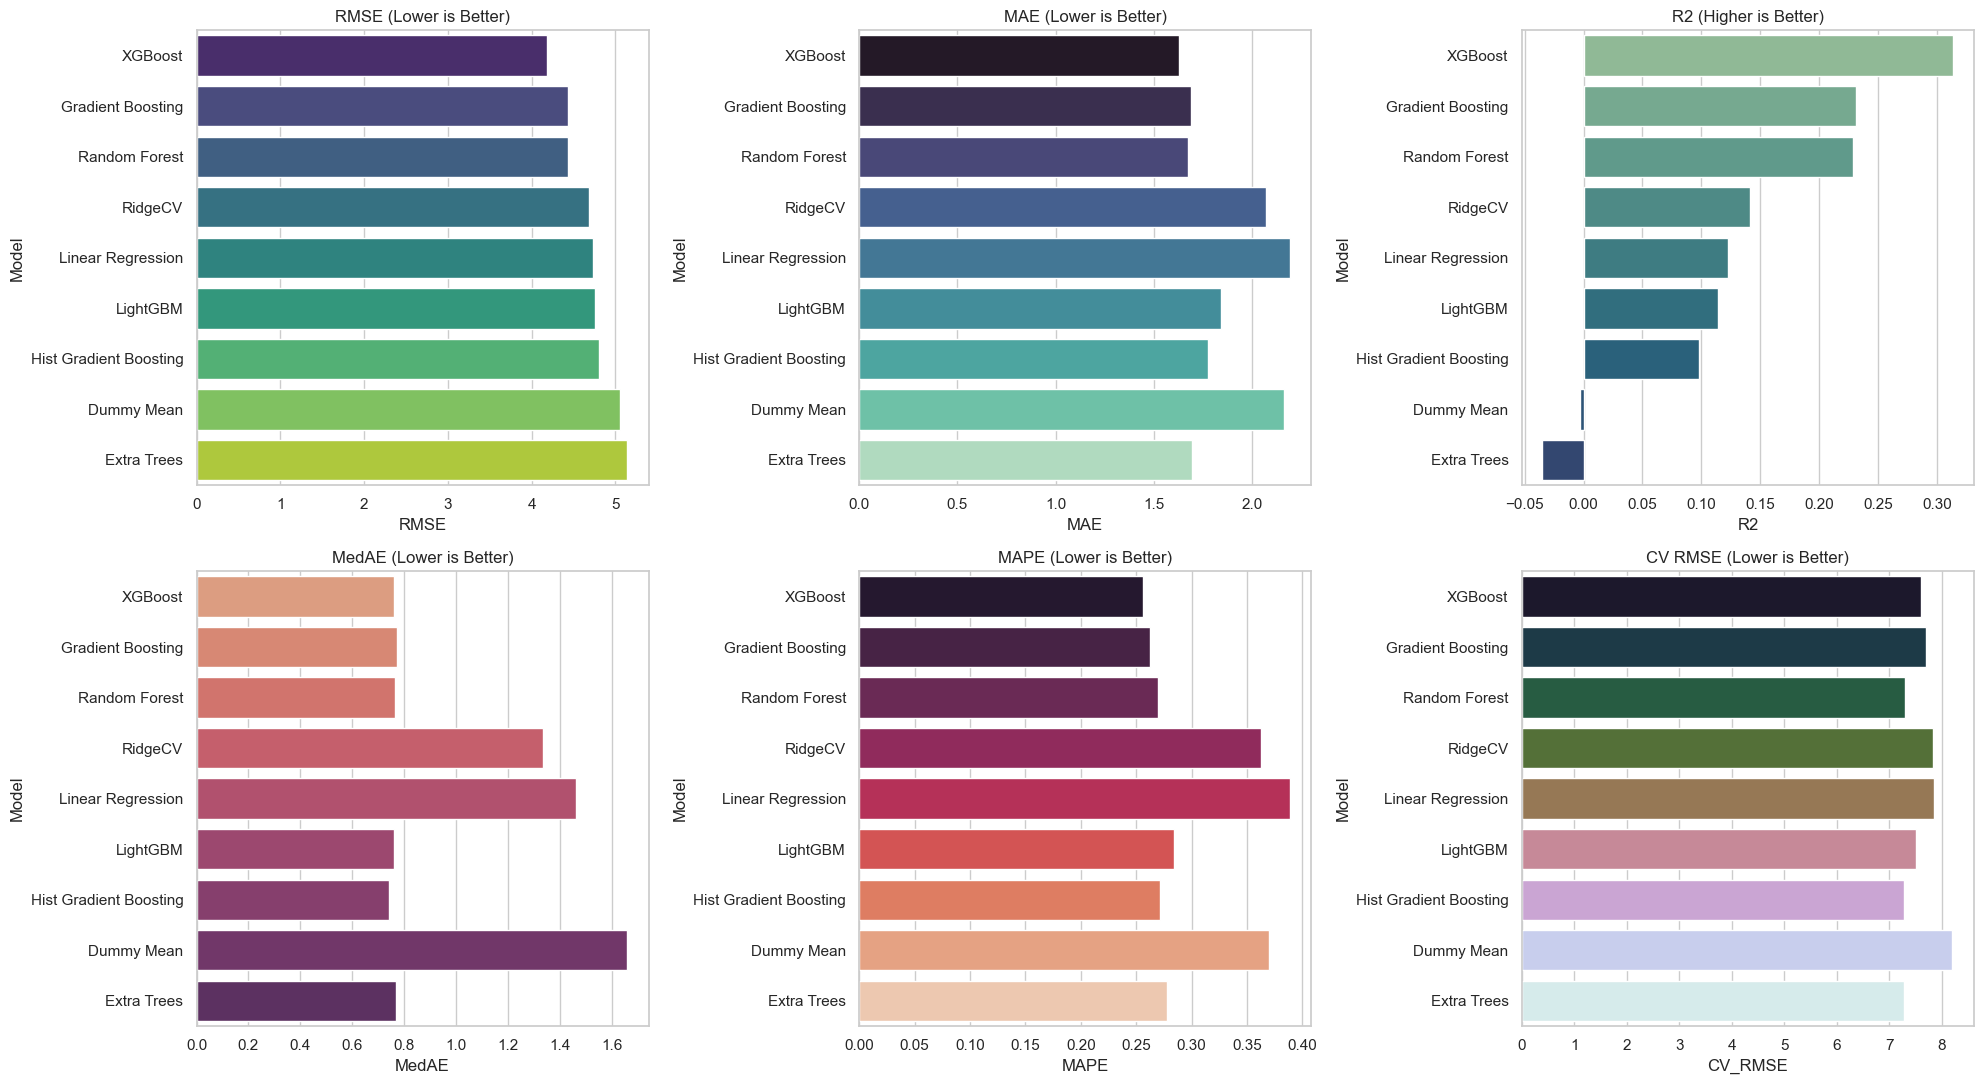

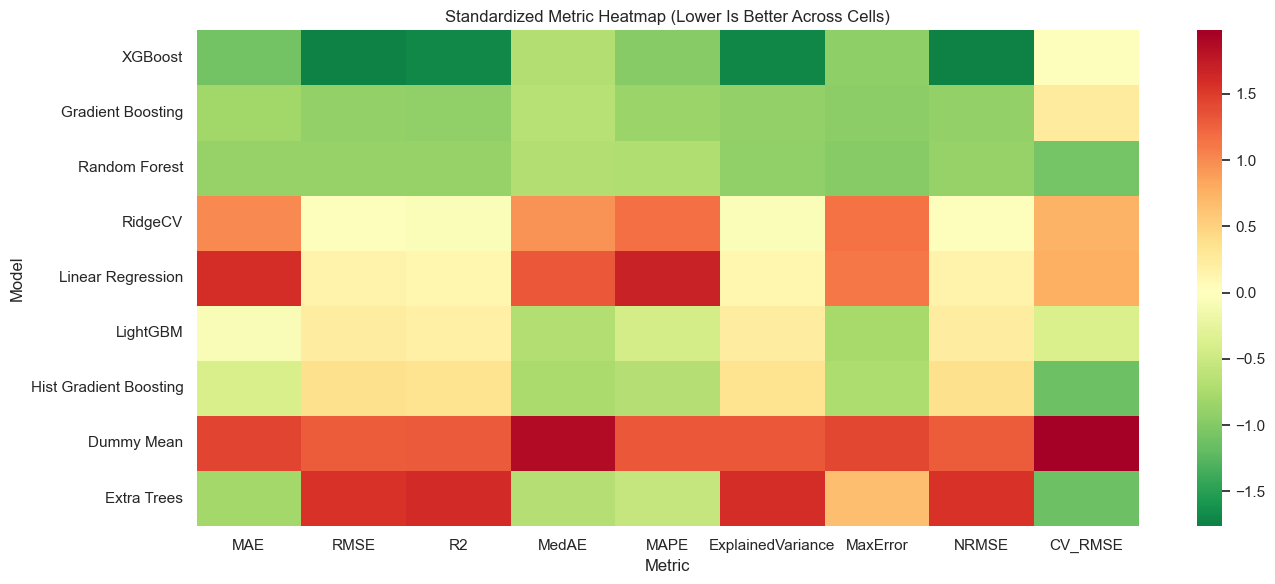

In [87]:
# Side-by-side metric comparison table for all models
metric_cols = ['MAE', 'RMSE', 'R2', 'MedAE', 'MAPE', 'ExplainedVariance', 'MaxError', 'NRMSE', 'CV_RMSE', 'FitTimeSec', 'AvgRank']
comparison_table = results_df[['Model'] + metric_cols].copy()

format_map = {
    'MAE': '{:.3f}',
    'RMSE': '{:.3f}',
    'R2': '{:.4f}',
    'MedAE': '{:.3f}',
    'MAPE': '{:.4f}',
    'ExplainedVariance': '{:.4f}',
    'MaxError': '{:.3f}',
    'NRMSE': '{:.4f}',
    'CV_RMSE': '{:.3f}',
    'FitTimeSec': '{:.3f}',
    'AvgRank': '{:.2f}'
}

display(comparison_table.style.format(format_map))

fig, axes = plt.subplots(2, 3, figsize=(20, 11))

sns.barplot(data=results_df, x='RMSE', y='Model', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('RMSE (Lower is Better)')

sns.barplot(data=results_df, x='MAE', y='Model', ax=axes[0, 1], palette='mako')
axes[0, 1].set_title('MAE (Lower is Better)')

sns.barplot(data=results_df, x='R2', y='Model', ax=axes[0, 2], palette='crest')
axes[0, 2].set_title('R2 (Higher is Better)')

sns.barplot(data=results_df, x='MedAE', y='Model', ax=axes[1, 0], palette='flare')
axes[1, 0].set_title('MedAE (Lower is Better)')

sns.barplot(data=results_df, x='MAPE', y='Model', ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('MAPE (Lower is Better)')

sns.barplot(data=results_df, x='CV_RMSE', y='Model', ax=axes[1, 2], palette='cubehelix')
axes[1, 2].set_title('CV RMSE (Lower is Better)')

plt.tight_layout()
plt.show()

# Heatmap on z-scored metrics (invert higher-is-better so all cells follow lower-is-better visual convention)
heat = results_df[['Model'] + metric_cols[:-2]].set_index('Model').copy()
heat['R2'] = -heat['R2']
heat['ExplainedVariance'] = -heat['ExplainedVariance']
heat_z = (heat - heat.mean()) / heat.std(ddof=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heat_z, cmap='RdYlGn_r', center=0, annot=False)
plt.title('Standardized Metric Heatmap (Lower Is Better Across Cells)')
plt.xlabel('Metric')
plt.ylabel('Model')
plt.tight_layout()
plt.show()



## 8. Best Model Diagnostics

We pick the model with lowest holdout RMSE.
Then inspect calibration (actual vs predicted) and residual shape.


In [88]:

best_model_name = results_df.iloc[0]['Model']
best_model = fitted_models[best_model_name]
y_pred_best = test_predictions[best_model_name]
residuals = y_test - y_pred_best

print('Best model by RMSE:', best_model_name)


Best model by RMSE: XGBoost


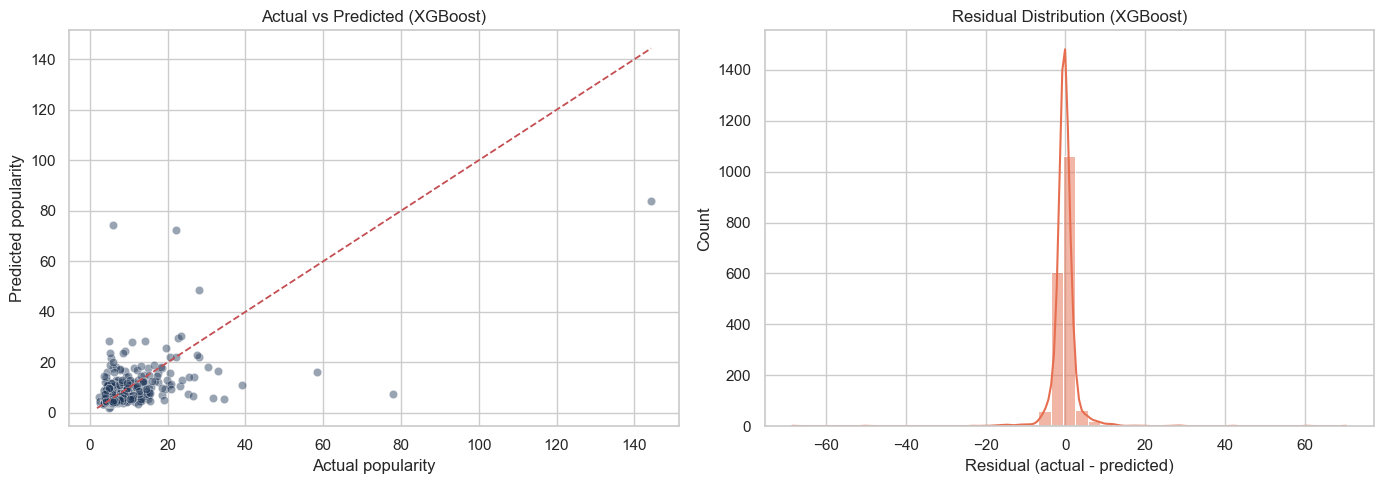

In [89]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.45, ax=axes[0], color='#1d3557')
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
axes[0].plot(lims, lims, 'r--', linewidth=1.3)
axes[0].set_title(f'Actual vs Predicted ({best_model_name})')
axes[0].set_xlabel('Actual popularity')
axes[0].set_ylabel('Predicted popularity')

sns.histplot(residuals, bins=45, kde=True, ax=axes[1], color='#e76f51')
axes[1].set_title(f'Residual Distribution ({best_model_name})')
axes[1].set_xlabel('Residual (actual - predicted)')

plt.tight_layout()
plt.show()



## 9. Model Interpretation

- For tree-based models: plot top feature importances.
- For linear models: plot largest absolute coefficients.


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/1419952097.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='Blues_r')


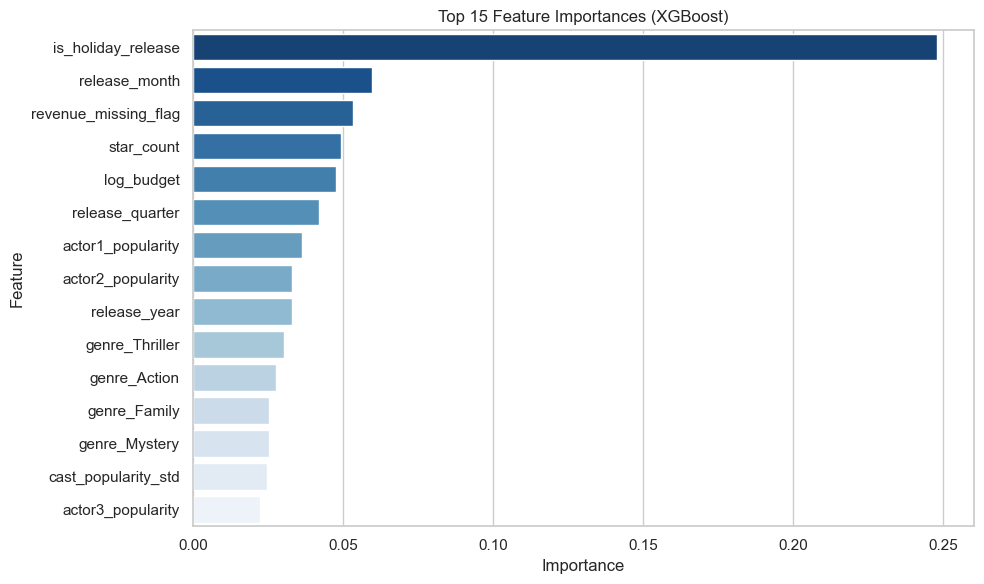

In [90]:

estimator = best_model.named_steps['model']
feature_names = X_train.columns

if hasattr(estimator, 'feature_importances_'):
    imp = pd.Series(estimator.feature_importances_, index=feature_names)
    top = imp.sort_values(ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top.values, y=top.index, palette='Blues_r')
    plt.title(f'Top 15 Feature Importances ({best_model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

elif hasattr(estimator, 'coef_'):
    coef = pd.Series(np.ravel(estimator.coef_), index=feature_names)
    top_idx = coef.abs().sort_values(ascending=False).head(15).index
    top_coef = coef.loc[top_idx].sort_values()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_coef.values, y=top_coef.index, palette='coolwarm')
    plt.title(f'Top 15 Coefficients ({best_model_name})')
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

else:
    print('No direct importances/coefficients available for this estimator.')



## 10. Summary and Next Steps
Compared baseline, linear, ensemble, and boosting models on the same pre-release feature set and evaluation protocol.
Raw-target holdout best was XGBoost (RMSE 4.185, MAE 1.626, R² 0.314), outperforming the dummy baseline.
Cross-validation showed ranking sensitivity, so robustness checks were necessary beyond a single split.
Fine-tuning improved XGBoost modestly (RMSE 4.149, R² 0.326).
The largest gain came from target transformation: Gradient Boosting + log1p(popularity) achieved best overall performance (RMSE 3.507, MAE 1.420, R² 0.519).


## 11. Robustness: Stronger CV + SHAP

This section adds:
- Repeated cross-validation on top holdout candidates for more stable ranking
- SHAP-based explainability for the best tree model (if `shap` is installed)


In [91]:
from sklearn.model_selection import RepeatedKFold, cross_validate

# Re-evaluate top models under repeated CV for stability (beyond single split)
TOP_N = min(3, len(results_df))
top_models = results_df['Model'].head(TOP_N).tolist()

rkfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
}

cv_rows = []
for name in top_models:
    model = models[name]
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=rkfold,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )

    rmse_vals = -scores['test_rmse']
    mae_vals = -scores['test_mae']
    r2_vals = scores['test_r2']

    cv_rows.append({
        'Model': name,
        'CV_RMSE_Mean': rmse_vals.mean(),
        'CV_RMSE_Std': rmse_vals.std(ddof=0),
        'CV_MAE_Mean': mae_vals.mean(),
        'CV_MAE_Std': mae_vals.std(ddof=0),
        'CV_R2_Mean': r2_vals.mean(),
        'CV_R2_Std': r2_vals.std(ddof=0),
    })

robust_cv_df = pd.DataFrame(cv_rows).sort_values('CV_RMSE_Mean').reset_index(drop=True)
print('Repeated CV (5x2) on top holdout models:')
display(robust_cv_df.style.format({
    'CV_RMSE_Mean': '{:.3f}', 'CV_RMSE_Std': '{:.3f}',
    'CV_MAE_Mean': '{:.3f}', 'CV_MAE_Std': '{:.3f}',
    'CV_R2_Mean': '{:.4f}', 'CV_R2_Std': '{:.4f}',
}))



Repeated CV (5x2) on top holdout models:


,Model,CV_RMSE_Mean,CV_RMSE_Std,CV_MAE_Mean,CV_MAE_Std,CV_R2_Mean,CV_R2_Std
0,Random Forest,7.165,1.898,1.842,0.153,0.1581,0.2064
1,Gradient Boosting,7.312,2.054,1.824,0.174,0.0799,0.4493
2,XGBoost,7.630,2.184,1.863,0.206,-0.0202,0.5064


SHAP summary for best model: XGBoost


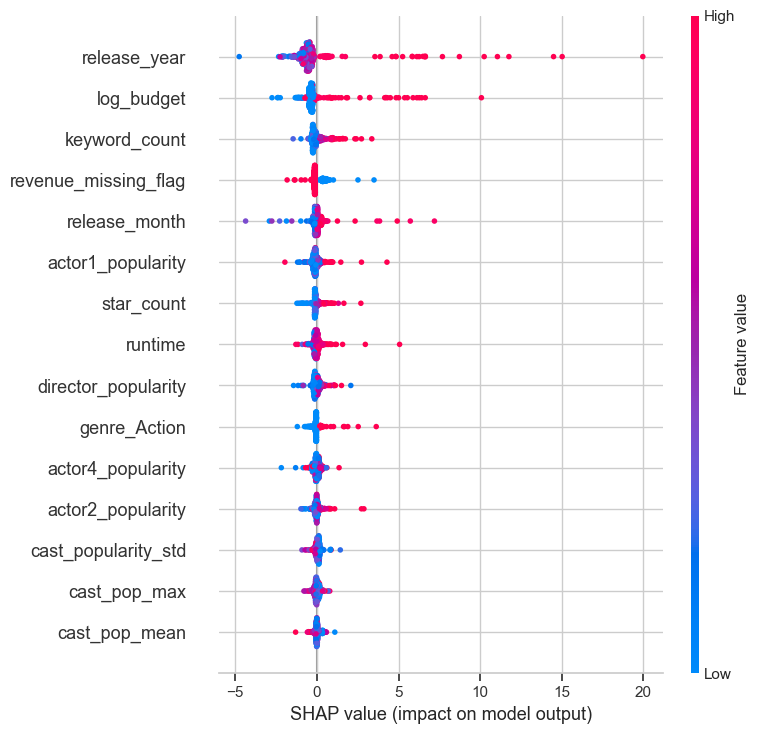

Top SHAP Features (XGBoost native contribs)


,Feature,MeanAbsSHAP
0,release_year,1.06851
1,log_budget,0.63181
2,keyword_count,0.28610
3,revenue_missing_flag,0.26253
4,release_month,0.24116
5,actor1_popularity,0.19804
6,star_count,0.17565
7,runtime,0.16781
8,director_popularity,0.16600
9,genre_Action,0.14012


In [92]:
# SHAP explainability with XGBoost-safe path + generic fallback
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

estimator = best_model.named_steps['model']

if not HAS_SHAP:
    print('SHAP not installed. Install with: pip install shap')
elif not hasattr(estimator, 'predict'):
    print('Best estimator not compatible with SHAP explainers.')
else:
    X_shap = X_train.sample(min(400, len(X_train)), random_state=RANDOM_STATE).copy()

    def _show_top_importance(values, X_ref, title='Top SHAP Features'):
        arr = np.abs(np.asarray(values))
        if arr.ndim == 3:  # multiclass
            arr = arr.mean(axis=0)
        mean_abs = arr.mean(axis=0)
        imp_df = (
            pd.DataFrame({'Feature': X_ref.columns, 'MeanAbsSHAP': mean_abs})
            .sort_values('MeanAbsSHAP', ascending=False)
            .head(15)
            .reset_index(drop=True)
        )
        print(title)
        display(imp_df.style.format({'MeanAbsSHAP': '{:.5f}'}))

    print(f'SHAP summary for best model: {best_model_name}')

    # 1) XGBoost best model: use native pred_contribs to avoid SHAP parser bug
    if best_model_name == 'XGBoost':
        try:
            import xgboost as xgb
            booster = estimator.get_booster()
            dmat = xgb.DMatrix(X_shap, feature_names=list(X_shap.columns))
            contrib = booster.predict(dmat, pred_contribs=True)  # includes bias term in last col
            shap_values = contrib[:, :-1]

            shap.summary_plot(shap_values, X_shap, max_display=15)
            _show_top_importance(shap_values, X_shap, title='Top SHAP Features (XGBoost native contribs)')

        except Exception as e:
            print(f'Native XGBoost SHAP path failed ({type(e).__name__}: {e}). Falling back to model-agnostic SHAP...')
            bg = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE).copy()
            explainer = shap.Explainer(lambda X: estimator.predict(pd.DataFrame(X, columns=X_shap.columns)), bg)
            sv = explainer(X_shap)
            shap.plots.beeswarm(sv, max_display=15)
            _show_top_importance(sv.values, X_shap, title='Top SHAP Features (agnostic fallback)')

    # 2) Other tree models
    elif best_model_name in ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'Hist Gradient Boosting', 'LightGBM']:
        try:
            explainer = shap.TreeExplainer(estimator)
            shap_values = explainer.shap_values(X_shap)
            shap.summary_plot(shap_values, X_shap, max_display=15)
            _show_top_importance(shap_values, X_shap)
        except Exception as e:
            print(f'TreeExplainer failed ({type(e).__name__}: {e}). Using model-agnostic SHAP fallback...')
            bg = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE).copy()
            explainer = shap.Explainer(lambda X: estimator.predict(pd.DataFrame(X, columns=X_shap.columns)), bg)
            sv = explainer(X_shap)
            shap.plots.beeswarm(sv, max_display=15)
            _show_top_importance(sv.values, X_shap, title='Top SHAP Features (agnostic fallback)')

    # 3) Linear/other models
    else:
        bg = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE).copy()
        explainer = shap.Explainer(lambda X: estimator.predict(pd.DataFrame(X, columns=X_shap.columns)), bg)
        sv = explainer(X_shap)
        shap.plots.beeswarm(sv, max_display=15)
        _show_top_importance(sv.values, X_shap)



## 12. Causal Inference (Observational, Approximate)

We estimate the effect of budget availability (`has_budget`) on popularity using:
- IPW (Inverse Probability Weighting)
- Doubly Robust (AIPW-style residualized estimator)

This is **not** a randomized experiment; interpret as sensitivity analysis under strong assumptions (no unobserved confounding).


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Treatment = has_budget (1 vs 0)


,Estimator,Estimate (popularity points),StdErr (DR only),95% CI Low (DR only),95% CI High (DR only)
0,IPW ATE,0.403,nan,nan,nan
1,Doubly Robust ATE,0.721,0.224,0.282,1.161


Propensity score range: [0.004, 0.999]
Treated share: 0.295


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/1361233187.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_df, x='T', y='ps', palette=['#e76f51', '#2a9d8f'], ax=axes[0, 1])
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/1361233187.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Control (0)', 'Treated (1)'])


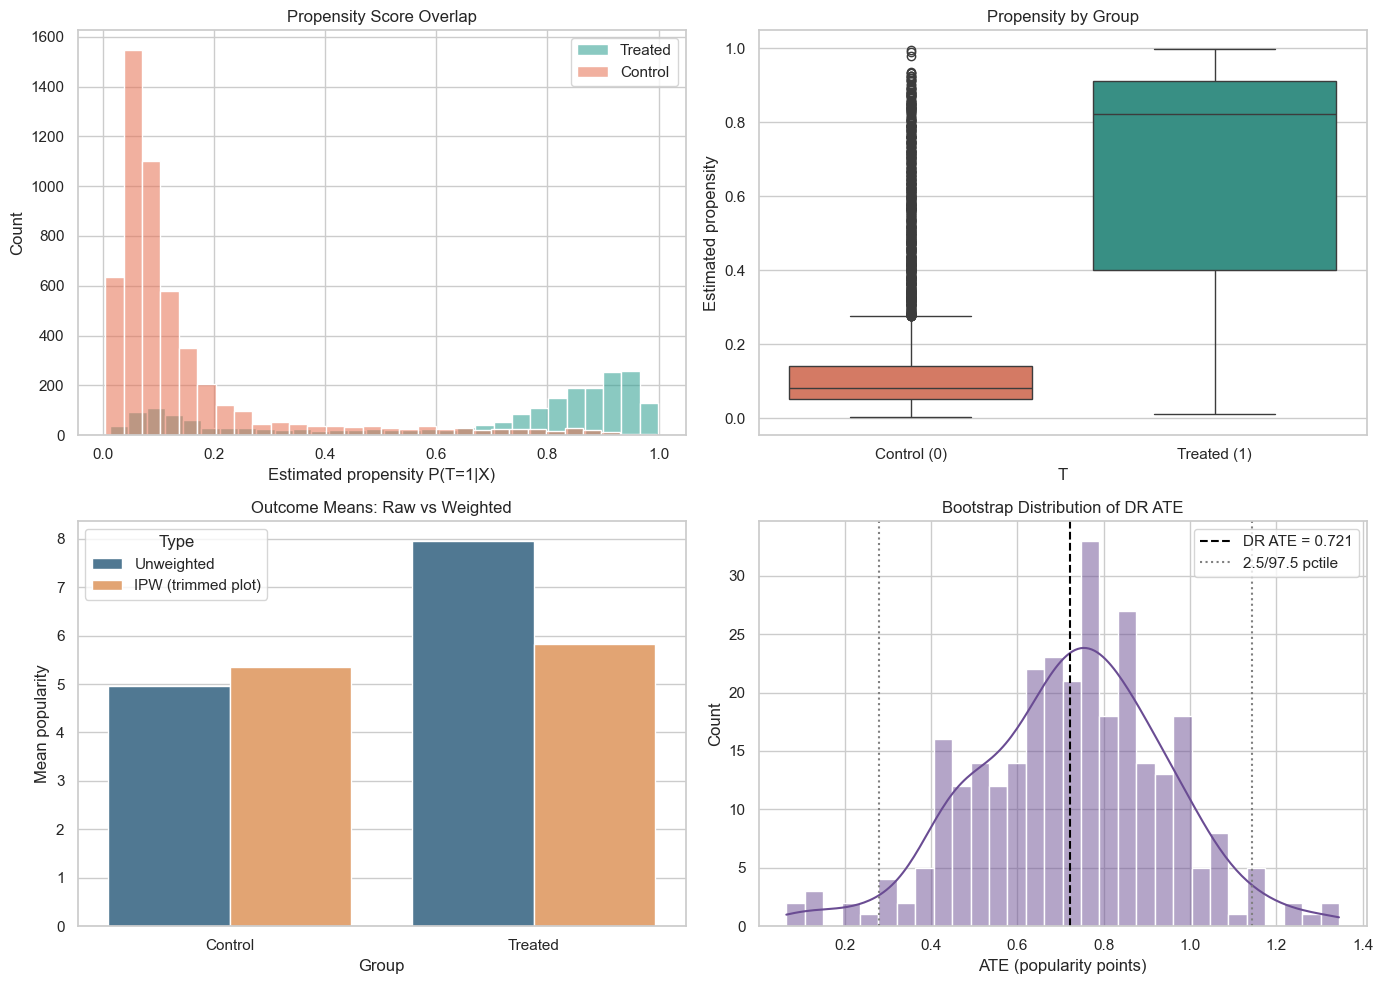

In [93]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Use training split to avoid peeking at test labels for this exploratory causal analysis
causal_df = X_train.copy()
causal_df = causal_df.assign(popularity=y_train.values)

if 'has_budget' not in causal_df.columns:
    print('Causal analysis skipped: has_budget not in feature set.')
else:
    T = causal_df['has_budget'].astype(int).values
    Y = causal_df['popularity'].values

    # Confounders: exclude treatment and direct treatment proxies
    drop_cols = {'has_budget', 'budget_missing_flag', 'log_budget', 'popularity'}
    conf_cols = [c for c in causal_df.columns if c not in drop_cols]
    Xc = causal_df[conf_cols].copy()

    # 1) Propensity model P(T=1|X)
    p_model = LogisticRegression(max_iter=2000)
    p_model.fit(Xc, T)
    ps = p_model.predict_proba(Xc)[:, 1]
    eps = 1e-3
    ps = np.clip(ps, eps, 1 - eps)

    # 2) Outcome models E[Y|T=1,X] and E[Y|T=0,X]
    y1_model = LinearRegression().fit(Xc[T == 1], Y[T == 1])
    y0_model = LinearRegression().fit(Xc[T == 0], Y[T == 0])

    mu1 = y1_model.predict(Xc)
    mu0 = y0_model.predict(Xc)

    # IPW ATE
    ipw_ate = np.mean((T * Y / ps) - ((1 - T) * Y / (1 - ps)))

    # Doubly robust (AIPW) ATE
    dr_scores = (mu1 - mu0) + T * (Y - mu1) / ps - (1 - T) * (Y - mu0) / (1 - ps)
    dr_ate = float(np.mean(dr_scores))
    dr_se = float(np.std(dr_scores, ddof=1) / np.sqrt(len(dr_scores)))
    dr_ci_low = dr_ate - 1.96 * dr_se
    dr_ci_high = dr_ate + 1.96 * dr_se

    out = pd.DataFrame({
        'Estimator': ['IPW ATE', 'Doubly Robust ATE'],
        'Estimate (popularity points)': [ipw_ate, dr_ate],
        'StdErr (DR only)': [np.nan, dr_se],
        '95% CI Low (DR only)': [np.nan, dr_ci_low],
        '95% CI High (DR only)': [np.nan, dr_ci_high],
    })

    print('Treatment = has_budget (1 vs 0)')
    display(out.style.format({
        'Estimate (popularity points)': '{:.3f}',
        'StdErr (DR only)': '{:.3f}',
        '95% CI Low (DR only)': '{:.3f}',
        '95% CI High (DR only)': '{:.3f}',
    }))

    print(f'Propensity score range: [{ps.min():.3f}, {ps.max():.3f}]')
    print(f'Treated share: {T.mean():.3f}')

    # -----------------------------
    # Visual diagnostics
    # -----------------------------
    viz_df = pd.DataFrame({
        'T': T,
        'Y': Y,
        'ps': ps,
        'w_ipw': np.where(T == 1, 1 / ps, 1 / (1 - ps))
    })

    # Trim extremely large weights for stable plotting only
    w_cap = np.quantile(viz_df['w_ipw'], 0.99)
    viz_df['w_plot'] = np.clip(viz_df['w_ipw'], 0, w_cap)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # (1) Propensity overlap by treatment
    sns.histplot(data=viz_df[viz_df['T'] == 1], x='ps', bins=30, alpha=0.55, color='#2a9d8f', ax=axes[0, 0], label='Treated')
    sns.histplot(data=viz_df[viz_df['T'] == 0], x='ps', bins=30, alpha=0.55, color='#e76f51', ax=axes[0, 0], label='Control')
    axes[0, 0].set_title('Propensity Score Overlap')
    axes[0, 0].set_xlabel('Estimated propensity P(T=1|X)')
    axes[0, 0].legend()

    # (2) Boxplot of propensity by treatment
    sns.boxplot(data=viz_df, x='T', y='ps', palette=['#e76f51', '#2a9d8f'], ax=axes[0, 1])
    axes[0, 1].set_xticklabels(['Control (0)', 'Treated (1)'])
    axes[0, 1].set_title('Propensity by Group')
    axes[0, 1].set_ylabel('Estimated propensity')

    # (3) Unweighted vs weighted mean outcome comparison
    unweighted_means = viz_df.groupby('T')['Y'].mean()
    weighted_treated = np.average(viz_df.loc[viz_df['T'] == 1, 'Y'], weights=viz_df.loc[viz_df['T'] == 1, 'w_plot'])
    weighted_control = np.average(viz_df.loc[viz_df['T'] == 0, 'Y'], weights=viz_df.loc[viz_df['T'] == 0, 'w_plot'])
    cmp = pd.DataFrame({
        'Group': ['Control', 'Treated', 'Control', 'Treated'],
        'Mean Y': [unweighted_means.loc[0], unweighted_means.loc[1], weighted_control, weighted_treated],
        'Type': ['Unweighted', 'Unweighted', 'IPW (trimmed plot)', 'IPW (trimmed plot)']
    })
    sns.barplot(data=cmp, x='Group', y='Mean Y', hue='Type', palette=['#457b9d', '#f4a261'], ax=axes[1, 0])
    axes[1, 0].set_title('Outcome Means: Raw vs Weighted')
    axes[1, 0].set_ylabel('Mean popularity')

    # (4) Bootstrap distribution of DR ATE
    rng = np.random.default_rng(42)
    B = 300
    dr_boot = []
    n = len(dr_scores)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        dr_boot.append(np.mean(dr_scores[idx]))
    dr_boot = np.array(dr_boot)

    sns.histplot(dr_boot, bins=30, kde=True, color='#6a4c93', ax=axes[1, 1])
    axes[1, 1].axvline(dr_ate, color='black', linestyle='--', label=f'DR ATE = {dr_ate:.3f}')
    axes[1, 1].axvline(np.percentile(dr_boot, 2.5), color='gray', linestyle=':', label='2.5/97.5 pctile')
    axes[1, 1].axvline(np.percentile(dr_boot, 97.5), color='gray', linestyle=':')
    axes[1, 1].set_title('Bootstrap Distribution of DR ATE')
    axes[1, 1].set_xlabel('ATE (popularity points)')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()



## 13. Fine-Tuning + Advanced Cross-Validation

This section adds:
- Hyperparameter fine-tuning for XGBoost (best baseline model)
- Repeated KFold comparison (untuned vs tuned)
- Temporal validation using release-year ordering (TimeSeriesSplit)


In [94]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, TimeSeriesSplit, cross_val_score

# -------------------------
# 13.1 XGBoost fine-tuning
# -------------------------
if 'XGBoost' not in models:
    print('XGBoost not available in this environment. Skipping fine-tuning block.')
    tuned_xgb = None
else:
    xgb_base = models['XGBoost'].named_steps['model']

    param_dist = {
        'n_estimators': [200, 300, 500, 700],
        'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'subsample': [0.7, 0.8, 0.85, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.85, 0.9, 1.0],
        'min_child_weight': [1, 2, 3, 5, 7],
        'reg_alpha': [0.0, 0.01, 0.05, 0.1, 0.5],
        'reg_lambda': [1.0, 1.5, 2.0, 3.0, 5.0],
    }

    search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_dist,
        n_iter=25,
        scoring='neg_root_mean_squared_error',
        cv=3,
        random_state=RANDOM_STATE,
        n_jobs=1,
        verbose=0,
    )

    search.fit(X_train, y_train)
    tuned_xgb = search.best_estimator_

    print('Best XGBoost params:')
    print(search.best_params_)
    print(f"Best CV RMSE (search): {-search.best_score_:.4f}")

    # Holdout comparison
    base_pred = models['XGBoost'].predict(X_test)
    tuned_pred = tuned_xgb.predict(X_test)

    base_rmse = np.sqrt(mean_squared_error(y_test, base_pred))
    tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_pred))
    base_mae = mean_absolute_error(y_test, base_pred)
    tuned_mae = mean_absolute_error(y_test, tuned_pred)
    base_r2 = r2_score(y_test, base_pred)
    tuned_r2 = r2_score(y_test, tuned_pred)

    holdout_cmp = pd.DataFrame({
        'Model': ['XGBoost Baseline', 'XGBoost Tuned'],
        'RMSE': [base_rmse, tuned_rmse],
        'MAE': [base_mae, tuned_mae],
        'R2': [base_r2, tuned_r2],
    })
    display(holdout_cmp.style.format({'RMSE':'{:.4f}', 'MAE':'{:.4f}', 'R2':'{:.4f}'}))

# ----------------------------------------
# 13.2 Repeated CV: baseline vs tuned model
# ----------------------------------------
if 'XGBoost' in models and tuned_xgb is not None:
    rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

    cv_base = -cross_val_score(models['XGBoost'], X_train, y_train, cv=rkf, scoring='neg_root_mean_squared_error', n_jobs=1)
    tuned_pipe = Pipeline([('model', tuned_xgb)])
    cv_tuned = -cross_val_score(tuned_pipe, X_train, y_train, cv=rkf, scoring='neg_root_mean_squared_error', n_jobs=1)

    cv_cmp = pd.DataFrame({
        'Model': ['XGBoost Baseline', 'XGBoost Tuned'],
        'CV_RMSE_Mean': [cv_base.mean(), cv_tuned.mean()],
        'CV_RMSE_Std': [cv_base.std(ddof=0), cv_tuned.std(ddof=0)],
    })
    print('Repeated CV (5x2) comparison:')
    display(cv_cmp.style.format({'CV_RMSE_Mean':'{:.4f}', 'CV_RMSE_Std':'{:.4f}'}))

# ----------------------------------------
# 13.3 Temporal CV (release_year-ordered)
# ----------------------------------------
if 'release_year' not in X.columns:
    print('Temporal CV skipped: release_year not found in features.')
else:
    order = np.argsort(X['release_year'].values)
    X_time = X.iloc[order].reset_index(drop=True)
    y_time = y.iloc[order].reset_index(drop=True)

    tscv = TimeSeriesSplit(n_splits=5)

    # compare best baseline model and tuned xgb when available
    candidates = [('Best Baseline', best_model)]
    if 'XGBoost' in models and tuned_xgb is not None:
        candidates.append(('XGBoost Tuned', Pipeline([('model', tuned_xgb)])))

    t_rows = []
    for name, model_obj in candidates:
        vals = -cross_val_score(model_obj, X_time, y_time, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=1)
        t_rows.append({'Model': name, 'Temporal_CV_RMSE_Mean': vals.mean(), 'Temporal_CV_RMSE_Std': vals.std(ddof=0)})

    temporal_df = pd.DataFrame(t_rows).sort_values('Temporal_CV_RMSE_Mean').reset_index(drop=True)
    print('Temporal CV (ordered by release_year):')
    display(temporal_df.style.format({'Temporal_CV_RMSE_Mean':'{:.4f}', 'Temporal_CV_RMSE_Std':'{:.4f}'}))



Best XGBoost params:
{'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV RMSE (search): 7.0487


,Model,RMSE,MAE,R2
0,XGBoost Baseline,4.1853,1.6265,0.3142
1,XGBoost Tuned,4.1495,1.5704,0.3259


Repeated CV (5x2) comparison:


,Model,CV_RMSE_Mean,CV_RMSE_Std
0,XGBoost Baseline,7.6297,2.1842
1,XGBoost Tuned,6.5618,2.0783


Temporal CV (ordered by release_year):


,Model,Temporal_CV_RMSE_Mean,Temporal_CV_RMSE_Std
0,XGBoost Tuned,5.1415,6.1880
1,Best Baseline,5.2041,6.1461


## 14. Causal Robustness Checks

Extends Section 12 with:
- Overlap-trimmed DR estimate (`0.05 <= propensity <= 0.95`)
- Placebo treatment test (randomized treatment labels)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

,Estimator,Estimate
0,DR ATE (full sample),0.7211
1,DR ATE (trimmed overlap),0.5070
2,Placebo DR mean,0.0046


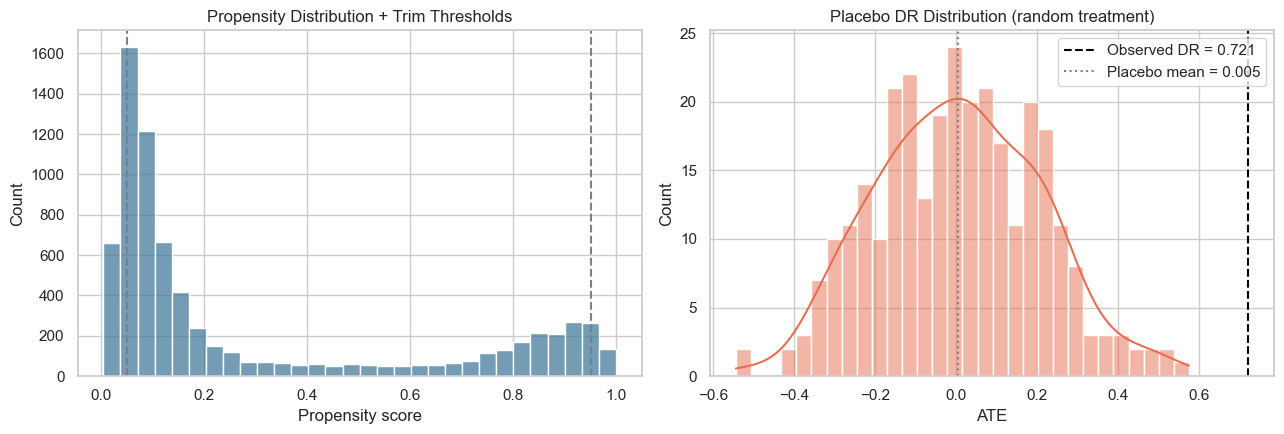

In [95]:
# Reuse treatment setup from Section 12
if 'has_budget' not in X_train.columns:
    print('Causal robustness skipped: has_budget not in training features.')
else:
    from sklearn.linear_model import LogisticRegression, LinearRegression

    cdf = X_train.copy().assign(popularity=y_train.values)
    T = cdf['has_budget'].astype(int).values
    Y = cdf['popularity'].values
    conf_cols = [c for c in cdf.columns if c not in {'has_budget', 'budget_missing_flag', 'log_budget', 'popularity'}]
    Xc = cdf[conf_cols]

    p_model = LogisticRegression(max_iter=2000)
    p_model.fit(Xc, T)
    ps = np.clip(p_model.predict_proba(Xc)[:, 1], 1e-3, 1 - 1e-3)

    y1_model = LinearRegression().fit(Xc[T == 1], Y[T == 1])
    y0_model = LinearRegression().fit(Xc[T == 0], Y[T == 0])
    mu1 = y1_model.predict(Xc)
    mu0 = y0_model.predict(Xc)

    dr_scores = (mu1 - mu0) + T * (Y - mu1) / ps - (1 - T) * (Y - mu0) / (1 - ps)
    dr_ate_full = dr_scores.mean()

    # Overlap trimming
    keep = (ps >= 0.05) & (ps <= 0.95)
    dr_scores_trim = dr_scores[keep]
    dr_ate_trim = dr_scores_trim.mean() if keep.sum() > 0 else np.nan

    # Placebo test: random treatment labels should produce near-zero ATE
    rng = np.random.default_rng(42)
    B = 300
    placebo = []
    for _ in range(B):
        T_perm = rng.permutation(T)
        p_perm = LogisticRegression(max_iter=2000).fit(Xc, T_perm)
        ps_perm = np.clip(p_perm.predict_proba(Xc)[:, 1], 1e-3, 1 - 1e-3)

        y1_perm = LinearRegression().fit(Xc[T_perm == 1], Y[T_perm == 1])
        y0_perm = LinearRegression().fit(Xc[T_perm == 0], Y[T_perm == 0])
        mu1_perm = y1_perm.predict(Xc)
        mu0_perm = y0_perm.predict(Xc)

        dr_perm = (mu1_perm - mu0_perm) + T_perm * (Y - mu1_perm) / ps_perm - (1 - T_perm) * (Y - mu0_perm) / (1 - ps_perm)
        placebo.append(dr_perm.mean())

    placebo = np.array(placebo)

    robust_df = pd.DataFrame({
        'Estimator': ['DR ATE (full sample)', 'DR ATE (trimmed overlap)', 'Placebo DR mean'],
        'Estimate': [dr_ate_full, dr_ate_trim, placebo.mean()],
    })
    display(robust_df.style.format({'Estimate':'{:.4f}'}))

    fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

    sns.histplot(ps, bins=30, color='#457b9d', ax=axes[0])
    axes[0].axvline(0.05, color='gray', linestyle='--')
    axes[0].axvline(0.95, color='gray', linestyle='--')
    axes[0].set_title('Propensity Distribution + Trim Thresholds')
    axes[0].set_xlabel('Propensity score')

    sns.histplot(placebo, bins=30, kde=True, color='#e76f51', ax=axes[1])
    axes[1].axvline(dr_ate_full, color='black', linestyle='--', label=f'Observed DR = {dr_ate_full:.3f}')
    axes[1].axvline(placebo.mean(), color='gray', linestyle=':', label=f'Placebo mean = {placebo.mean():.3f}')
    axes[1].set_title('Placebo DR Distribution (random treatment)')
    axes[1].set_xlabel('ATE')
    axes[1].legend()

    plt.tight_layout()
    plt.show()



## 15. Target Transform Ablation (Raw vs log1p)

This section checks whether modeling `log1p(popularity)` improves realism and error stability.
Predictions from the log model are back-transformed with `expm1` for evaluation on original scale.


,Model,Target,RMSE,MAE,R2,P99_Pred,Max_Pred
0,Extra Trees,log1p(popularity),4.1156,1.4734,0.3368,14.91,58.61
1,Extra Trees,raw popularity,5.1416,1.6904,-0.0350,20.76,121.09
2,Gradient Boosting,log1p(popularity),3.5067,1.4196,0.5186,14.12,110.02
3,Gradient Boosting,raw popularity,4.4313,1.6860,0.2312,19.66,83.36
4,Hist Gradient Boosting,log1p(popularity),3.9801,1.4370,0.3798,16.37,59.98
5,Hist Gradient Boosting,raw popularity,4.8001,1.7725,0.0979,23.12,77.13
6,XGBoost,log1p(popularity),3.7041,1.4060,0.4628,15.31,65.69
7,XGBoost,raw popularity,4.1853,1.6265,0.3142,19.42,83.71


Ablation deltas (log target minus raw target):


,Model,Delta_RMSE_log_minus_raw,Delta_MAE_log_minus_raw,Delta_R2_log_minus_raw,Delta_MaxPred_log_minus_raw
0,Extra Trees,-1.0260,-0.2170,+0.3719,-62.48
1,Gradient Boosting,-0.9246,-0.2664,+0.2874,+26.66
2,Hist Gradient Boosting,-0.8199,-0.3355,+0.2819,-17.15
3,XGBoost,-0.4813,-0.2204,+0.1487,-18.02


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_38608/3514904010.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Setting', y='RMSE', palette='viridis')


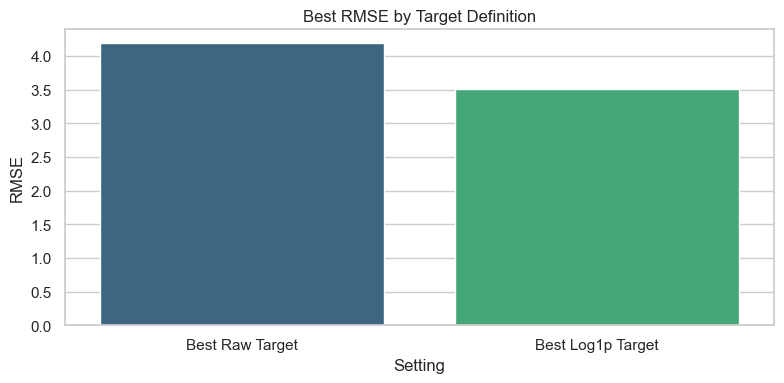

In [96]:
# Compare raw-target vs log1p-target for top models
from sklearn.base import clone

ABLATION_MODELS = [m for m in ['XGBoost', 'Extra Trees', 'Gradient Boosting', 'Hist Gradient Boosting'] if m in models]

rows = []
y_train_log = np.log1p(y_train)

for model_name in ABLATION_MODELS:
    base_pipe = models[model_name]

    # Raw target fit
    raw_pipe = clone(base_pipe)
    raw_pipe.fit(X_train, y_train)
    pred_raw = raw_pipe.predict(X_test)

    # Log target fit, then back-transform
    log_pipe = clone(base_pipe)
    log_pipe.fit(X_train, y_train_log)
    pred_log = np.expm1(log_pipe.predict(X_test))
    pred_log = np.clip(pred_log, 0, None)

    rows.append({
        'Model': model_name,
        'Target': 'raw popularity',
        'RMSE': np.sqrt(mean_squared_error(y_test, pred_raw)),
        'MAE': mean_absolute_error(y_test, pred_raw),
        'R2': r2_score(y_test, pred_raw),
        'P99_Pred': float(np.percentile(pred_raw, 99)),
        'Max_Pred': float(np.max(pred_raw)),
    })

    rows.append({
        'Model': model_name,
        'Target': 'log1p(popularity)',
        'RMSE': np.sqrt(mean_squared_error(y_test, pred_log)),
        'MAE': mean_absolute_error(y_test, pred_log),
        'R2': r2_score(y_test, pred_log),
        'P99_Pred': float(np.percentile(pred_log, 99)),
        'Max_Pred': float(np.max(pred_log)),
    })

ablation_df = pd.DataFrame(rows).sort_values(['Model', 'RMSE']).reset_index(drop=True)
display(ablation_df.style.format({'RMSE':'{:.4f}','MAE':'{:.4f}','R2':'{:.4f}','P99_Pred':'{:.2f}','Max_Pred':'{:.2f}'}))

# Improvement summary (log - raw), lower is better for RMSE/MAE
summary_rows = []
for m in ablation_df['Model'].unique():
    raw_row = ablation_df[(ablation_df['Model']==m) & (ablation_df['Target']=='raw popularity')].iloc[0]
    log_row = ablation_df[(ablation_df['Model']==m) & (ablation_df['Target']=='log1p(popularity)')].iloc[0]
    summary_rows.append({
        'Model': m,
        'Delta_RMSE_log_minus_raw': log_row['RMSE'] - raw_row['RMSE'],
        'Delta_MAE_log_minus_raw': log_row['MAE'] - raw_row['MAE'],
        'Delta_R2_log_minus_raw': log_row['R2'] - raw_row['R2'],
        'Delta_MaxPred_log_minus_raw': log_row['Max_Pred'] - raw_row['Max_Pred'],
    })

summary_df = pd.DataFrame(summary_rows).sort_values('Delta_RMSE_log_minus_raw')
print('Ablation deltas (log target minus raw target):')
display(summary_df.style.format({
    'Delta_RMSE_log_minus_raw':'{:+.4f}',
    'Delta_MAE_log_minus_raw':'{:+.4f}',
    'Delta_R2_log_minus_raw':'{:+.4f}',
    'Delta_MaxPred_log_minus_raw':'{:+.2f}',
}))

# Simple visual for best model in each target setting
best_raw = ablation_df[ablation_df['Target']=='raw popularity'].sort_values('RMSE').iloc[0]
best_log = ablation_df[ablation_df['Target']=='log1p(popularity)'].sort_values('RMSE').iloc[0]

plt.figure(figsize=(8,4))
plot_df = pd.DataFrame({
    'Setting': ['Best Raw Target', 'Best Log1p Target'],
    'RMSE': [best_raw['RMSE'], best_log['RMSE']]
})
sns.barplot(data=plot_df, x='Setting', y='RMSE', palette='viridis')
plt.title('Best RMSE by Target Definition')
plt.tight_layout()
plt.show()



## 16. Final Popularity Model Update (Adopt log1p Target)

Based on Section 15 ablation, we select the best `log1p(popularity)` model and treat it as final for popularity prediction.
Evaluation is reported on original popularity scale via `expm1` back-transform.


In [97]:
from sklearn.base import clone

# Rebuild ablation quickly if this section is run independently
if 'ablation_df' not in globals():
    ABLATION_MODELS = [m for m in ['XGBoost', 'Extra Trees', 'Gradient Boosting', 'Hist Gradient Boosting'] if m in models]
    rows = []
    y_train_log = np.log1p(y_train)
    for model_name in ABLATION_MODELS:
        base_pipe = models[model_name]

        raw_pipe = clone(base_pipe)
        raw_pipe.fit(X_train, y_train)
        pred_raw = raw_pipe.predict(X_test)

        log_pipe = clone(base_pipe)
        log_pipe.fit(X_train, y_train_log)
        pred_log = np.expm1(log_pipe.predict(X_test))
        pred_log = np.clip(pred_log, 0, None)

        rows.append({'Model': model_name, 'Target': 'raw popularity',
                     'RMSE': np.sqrt(mean_squared_error(y_test, pred_raw)),
                     'MAE': mean_absolute_error(y_test, pred_raw),
                     'R2': r2_score(y_test, pred_raw)})
        rows.append({'Model': model_name, 'Target': 'log1p(popularity)',
                     'RMSE': np.sqrt(mean_squared_error(y_test, pred_log)),
                     'MAE': mean_absolute_error(y_test, pred_log),
                     'R2': r2_score(y_test, pred_log)})

    ablation_df = pd.DataFrame(rows)

# Select best log-target model by RMSE
best_log_row = (
    ablation_df[ablation_df['Target'] == 'log1p(popularity)']
    .sort_values('RMSE')
    .iloc[0]
)
final_log_model_name = best_log_row['Model']
print(f"Selected final popularity model: {final_log_model_name} (trained on log1p target)")

# Train selected model on log1p(y)
final_log_pipeline = clone(models[final_log_model_name])
final_log_pipeline.fit(X_train, np.log1p(y_train))

# Holdout evaluation on original scale
y_pred_final = np.expm1(final_log_pipeline.predict(X_test))
y_pred_final = np.clip(y_pred_final, 0, None)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

final_eval_df = pd.DataFrame({
    'Final Model': [f'{final_log_model_name} + log1p target'],
    'RMSE (orig scale)': [final_rmse],
    'MAE (orig scale)': [final_mae],
    'R2 (orig scale)': [final_r2],
})
display(final_eval_df.style.format({'RMSE (orig scale)': '{:.4f}', 'MAE (orig scale)': '{:.4f}', 'R2 (orig scale)': '{:.4f}'}))

# Compare to previous best raw-target model
raw_best_row = (
    ablation_df[ablation_df['Target'] == 'raw popularity']
    .sort_values('RMSE')
    .iloc[0]
)
compare_final_df = pd.DataFrame({
    'Setting': ['Best Raw Target', 'Best Log1p Target (Final)'],
    'Model': [raw_best_row['Model'], final_log_model_name],
    'RMSE': [raw_best_row['RMSE'], final_rmse],
    'MAE': [raw_best_row['MAE'], final_mae],
    'R2': [raw_best_row['R2'], final_r2],
})
display(compare_final_df.style.format({'RMSE': '{:.4f}', 'MAE': '{:.4f}', 'R2': '{:.4f}'}))

# Save notebook-level final model variables for downstream export/use
# IMPORTANT: predictions from this model must be back-transformed with expm1.
final_popularity_model = final_log_pipeline
final_popularity_model_target_transform = 'log1p'

print('Notebook final model variables set: final_popularity_model, final_popularity_model_target_transform')



Selected final popularity model: Gradient Boosting (trained on log1p target)


,Final Model,RMSE (orig scale),MAE (orig scale),R2 (orig scale)
0,Gradient Boosting + log1p target,3.5067,1.4196,0.5186


,Setting,Model,RMSE,MAE,R2
0,Best Raw Target,XGBoost,4.1853,1.6265,0.3142
1,Best Log1p Target (Final),Gradient Boosting,3.5067,1.4196,0.5186


Notebook final model variables set: final_popularity_model, final_popularity_model_target_transform


### Deployment Note
- This final popularity model predicts `log1p(popularity)`.
- For app/API inference: `pred_popularity = expm1(model.predict(X))`, clipped at 0.
- If you export this model, also export `target_transform = "log1p"` metadata.


## 17. Final Model Validation and Fine-Tuning (Selected log1p Model)

This section focuses on the final selected popularity model (`final_log_model_name`) and adds:
- Repeated cross-validation on the training split, evaluated on original popularity scale
- Targeted fine-tuning when the selected model is `Gradient Boosting`


In [98]:
from sklearn.model_selection import RepeatedKFold
from sklearn.base import clone

# Resolve selected final model name
if 'final_log_model_name' in globals():
    selected_final_model_name = final_log_model_name
elif 'best_log_row' in globals():
    selected_final_model_name = best_log_row['Model']
else:
    selected_final_model_name = (
        ablation_df[ablation_df['Target'] == 'log1p(popularity)']
        .sort_values('RMSE')
        .iloc[0]['Model']
    )

print(f"Selected model for validation: {selected_final_model_name} (log1p target)")

base_final_pipe = clone(models[selected_final_model_name])
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

fold_rows = []
for fold_id, (tr_idx, va_idx) in enumerate(rkf.split(X_train), start=1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    model_fold = clone(base_final_pipe)
    model_fold.fit(X_tr, np.log1p(y_tr))

    pred_va = np.expm1(model_fold.predict(X_va))
    pred_va = np.clip(pred_va, 0, None)

    fold_rows.append({
        'Fold': fold_id,
        'RMSE': np.sqrt(mean_squared_error(y_va, pred_va)),
        'MAE': mean_absolute_error(y_va, pred_va),
        'R2': r2_score(y_va, pred_va),
    })

final_cv_df = pd.DataFrame(fold_rows)
print('Repeated CV (5x2) for final selected log model:')
display(final_cv_df.describe().loc[['mean', 'std']].style.format({'RMSE':'{:.4f}','MAE':'{:.4f}','R2':'{:.4f}'}))


Selected model for validation: Gradient Boosting (log1p target)
Repeated CV (5x2) for final selected log model:


,Fold,RMSE,MAE,R2
mean,5.500000,6.9330,1.5891,0.2537
std,3.027650,2.4240,0.1588,0.0989


In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Fine-tune only when selected final model is Gradient Boosting
if selected_final_model_name != 'Gradient Boosting':
    print(f"Fine-tuning block skipped: selected final model is {selected_final_model_name}, not Gradient Boosting.")
    tuned_final_model = None
else:
    gb_pipe = clone(models['Gradient Boosting'])

    # Tune GBR hyperparameters on log-target objective
    param_dist = {
        'model__n_estimators': randint(150, 900),
        'model__learning_rate': uniform(0.01, 0.12),
        'model__max_depth': randint(2, 6),
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 12),
        'model__subsample': uniform(0.65, 0.35),
        'model__max_features': ['sqrt', 'log2', None],
    }

    gb_search = RandomizedSearchCV(
        estimator=gb_pipe,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_root_mean_squared_error',
        cv=3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0,
    )

    # Search on log1p target
    gb_search.fit(X_train, np.log1p(y_train))
    tuned_final_model = gb_search.best_estimator_

    print('Best Gradient Boosting params (log-target search):')
    print(gb_search.best_params_)
    print(f"Best CV RMSE in log-space: {-gb_search.best_score_:.4f}")

    # Holdout comparison on original scale
    base_model = clone(models['Gradient Boosting'])
    base_model.fit(X_train, np.log1p(y_train))

    base_pred = np.expm1(base_model.predict(X_test))
    tuned_pred = np.expm1(tuned_final_model.predict(X_test))
    base_pred = np.clip(base_pred, 0, None)
    tuned_pred = np.clip(tuned_pred, 0, None)

    compare_df = pd.DataFrame([
        {
            'Model': 'Gradient Boosting (base, log1p target)',
            'RMSE': np.sqrt(mean_squared_error(y_test, base_pred)),
            'MAE': mean_absolute_error(y_test, base_pred),
            'R2': r2_score(y_test, base_pred),
        },
        {
            'Model': 'Gradient Boosting (tuned, log1p target)',
            'RMSE': np.sqrt(mean_squared_error(y_test, tuned_pred)),
            'MAE': mean_absolute_error(y_test, tuned_pred),
            'R2': r2_score(y_test, tuned_pred),
        },
    ])

    display(compare_df.style.format({'RMSE':'{:.4f}','MAE':'{:.4f}','R2':'{:.4f}'}))


Best Gradient Boosting params (log-target search):
{'model__learning_rate': 0.019702399159925832, 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 7, 'model__n_estimators': 429, 'model__subsample': 0.8146052220561135}
Best CV RMSE in log-space: 0.2589


,Model,RMSE,MAE,R2
0,"Gradient Boosting (base, log1p target)",3.5067,1.4196,0.5186
1,"Gradient Boosting (tuned, log1p target)",3.7724,1.4114,0.4428


## 18. SHAP Explainability for Final Selected Model

Computes SHAP values for the final selected `log1p` popularity model and reports top drivers.
For tree models (including Gradient Boosting), uses `TreeExplainer`.


SHAP summary for final selected model: Gradient Boosting (log1p target)


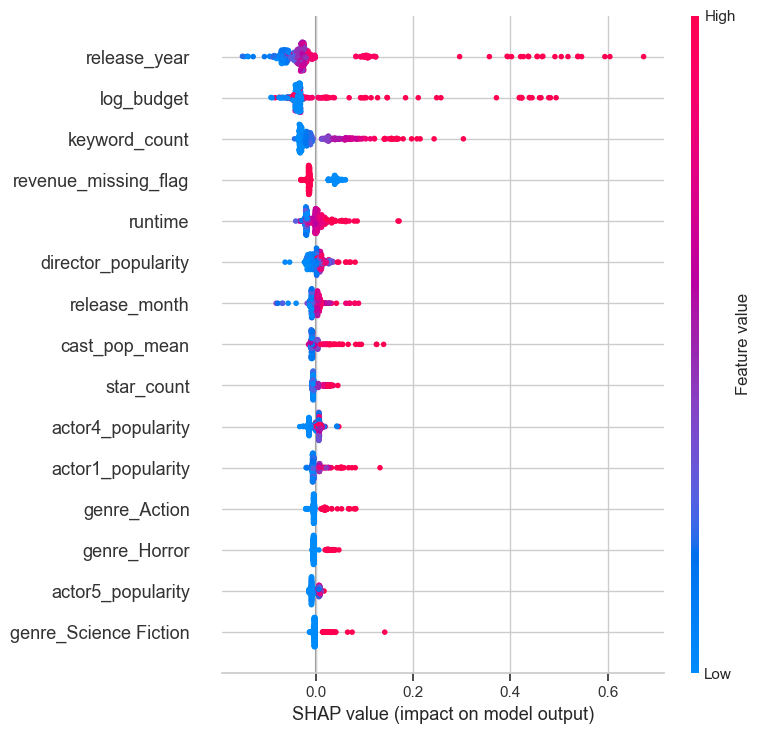

,Feature,MeanAbsSHAP
0,release_year,0.06894
1,log_budget,0.05510
2,keyword_count,0.03888
3,revenue_missing_flag,0.02109
4,runtime,0.01405
5,director_popularity,0.01121
6,release_month,0.00932
7,cast_pop_mean,0.00917
8,star_count,0.00836
9,actor4_popularity,0.00834


In [100]:
# SHAP for final selected model (log1p target)
try:
    import shap
    HAS_SHAP_FINAL = True
except Exception:
    HAS_SHAP_FINAL = False

from sklearn.base import clone

if not HAS_SHAP_FINAL:
    print('SHAP not installed. Install with: pip install shap')
else:
    # Resolve selected final model name
    if 'selected_final_model_name' not in globals():
        if 'final_log_model_name' in globals():
            selected_final_model_name = final_log_model_name
        elif 'best_log_row' in globals():
            selected_final_model_name = best_log_row['Model']
        else:
            selected_final_model_name = (
                ablation_df[ablation_df['Target'] == 'log1p(popularity)']
                .sort_values('RMSE')
                .iloc[0]['Model']
            )

    final_shap_model = clone(models[selected_final_model_name])
    final_shap_model.fit(X_train, np.log1p(y_train))
    final_estimator = final_shap_model.named_steps.get('model', final_shap_model)

    X_shap_final = X_train.sample(min(400, len(X_train)), random_state=RANDOM_STATE).copy()

    print(f'SHAP summary for final selected model: {selected_final_model_name} (log1p target)')

    try:
        if selected_final_model_name in ['Gradient Boosting', 'Hist Gradient Boosting', 'Extra Trees', 'Random Forest', 'XGBoost', 'LightGBM']:
            explainer = shap.TreeExplainer(final_estimator)
            shap_values = explainer.shap_values(X_shap_final)
            shap.summary_plot(shap_values, X_shap_final, max_display=15)

            arr = np.abs(np.asarray(shap_values))
            if arr.ndim == 3:
                arr = arr.mean(axis=0)
            mean_abs = arr.mean(axis=0)
        else:
            explainer = shap.Explainer(final_estimator.predict, X_shap_final)
            sv = explainer(X_shap_final)
            shap.plots.beeswarm(sv, max_display=15)
            mean_abs = np.abs(np.asarray(sv.values)).mean(axis=0)

        shap_imp_final = (
            pd.DataFrame({'Feature': X_shap_final.columns, 'MeanAbsSHAP': mean_abs})
            .sort_values('MeanAbsSHAP', ascending=False)
            .head(15)
            .reset_index(drop=True)
        )
        display(shap_imp_final.style.format({'MeanAbsSHAP': '{:.5f}'}))

    except Exception as e:
        print(f'SHAP computation failed for {selected_final_model_name}: {type(e).__name__}: {e}')
        print('Tip: upgrade/downgrade shap and model libraries to compatible versions.')
